In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
df = pd.read_excel("data.xlsx")

In [63]:
df

,leader,polygon,id,subpolygon,stating_type,date_list,mileage_list,date_telematics,mileage_telematics,penalty,driving_style
0,True,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,NaT,158.0,NaT,140.26,17.0,3.5
1,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-04,9.0,2024-04-02,3.00,1.0,3.5
2,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-08,5.0,2024-04-08,5.00,1.0,3.5
3,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-09,7.0,2024-04-09,7.00,NaN,3.5
4,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-10,12.0,2024-04-10,12.00,2.0,3.5
...,...,...,...,...,...,...,...,...,...,...,...
4396,False,Северная ДМ,Р390ХН07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,2024-04-28,8.0,2024-04-28,8.00,NaN,5.2
4397,False,Северная ДМ,Р390ХН07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,2024-04-30,46.0,2024-04-30,46.00,NaN,5.2
4398,True,Северная ДМ,М777КХ07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,NaT,11.0,NaT,0.00,0.0,5.3
4399,False,Северная ДМ,М777КХ07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,2024-04-05,3.0,NaT,NaN,9.0,5.3


In [64]:
df['penalty'] = df['penalty'].fillna(1)
if (df['penalty'] == 0).any():
    df['penalty'] == 1

df['penalty']

0       17.0
1        1.0
2        1.0
3        1.0
4        2.0
        ... 
4396     1.0
4397     1.0
4398     0.0
4399     9.0
4400     1.0
Name: penalty, Length: 4401, dtype: float64

# Графики по штрафам, манере вождения и пробегу

In [136]:
def get_polygons_rate(df_group):
	rate_polygons = df_group[['mileage_list', 'mileage_telematics', 'penalty']].sum()
	rate_polygons = rate_polygons.join(df_group[['driving_style']].mean())
	rate_polygons = rate_polygons.join(df_group[['driving_style']].count().rename(columns={'driving_style': 'cnt'}))

	rate_polygons['mileage_deviation'] = (1 - (rate_polygons['mileage_list'] / rate_polygons['mileage_telematics'])).abs()
	rate_polygons['mileage_deviation_score'] = 1 / (np.e ** rate_polygons['mileage_deviation'])

	rate_polygons['driving_style_score'] = rate_polygons['driving_style'] / 6

	rate_polygons['penalty_score'] = 1 / (rate_polygons['penalty'] / rate_polygons['cnt'])

	rate_polygons['result_score'] = rate_polygons['mileage_deviation_score'] * 0.57 + rate_polygons['penalty_score'] * 0.21 + rate_polygons['driving_style_score'] * 0.21

	return rate_polygons

In [139]:
rate_polygons_group = df[df.leader == True].groupby('polygon')
rate_polygons = get_polygons_rate(rate_polygons_group)

rate_polygons = rate_polygons.reset_index()
rate_polygons

,polygon,mileage_list,mileage_telematics,penalty,driving_style,cnt,mileage_deviation,mileage_deviation_score,driving_style_score,penalty_score,result_score
0,Горьковская дир,163788.27,147695.28,621.0,3.868116,138,0.108961,0.896766,0.644686,0.222222,0.693207
1,Клнг. ДУТСК,27903.42,4618.77,131.0,3.596875,32,5.041310,0.006465,0.599479,0.244275,0.180874
2,Московская ДМ,196578.51,183048.09,676.0,3.342466,146,0.073917,0.928749,0.557078,0.215976,0.691728
3,Окт ДМ,46844.80,48498.36,360.0,3.619753,81,0.034095,0.966480,0.603292,0.225000,0.724835
4,Северная ДМ,275400.14,204838.43,394.0,4.287179,78,0.344475,0.708592,0.714530,0.197970,0.595522


## Манера вождения

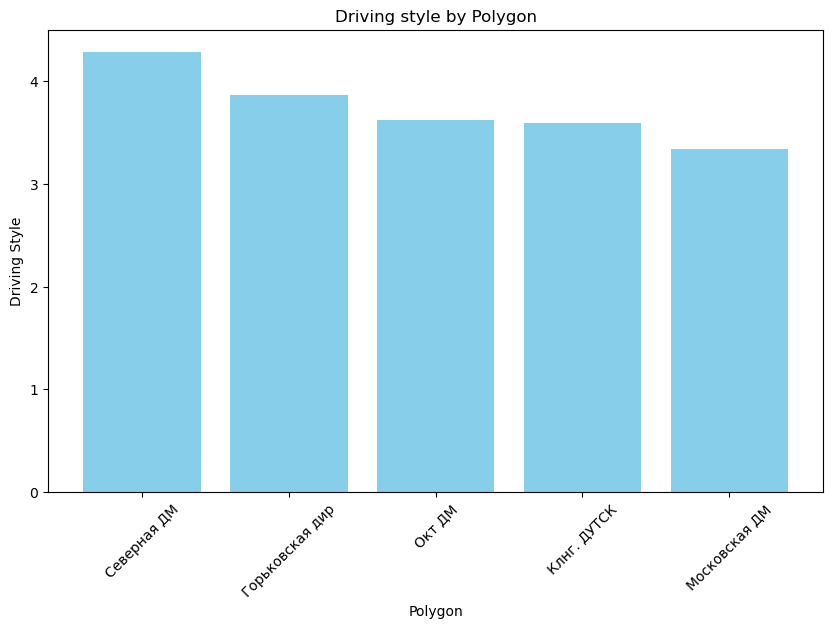

,polygon,driving_style
4,Северная ДМ,4.287179
0,Горьковская дир,3.868116
3,Окт ДМ,3.619753
1,Клнг. ДУТСК,3.596875
2,Московская ДМ,3.342466


In [66]:
graph1 = pd.DataFrame({'polygon': rate_polygons['polygon'], 'driving_style': rate_polygons['driving_style']})
graph1_sorted = graph1.sort_values(by='driving_style', ascending=False)
graph1_sorted

plt.figure(figsize=(10, 6))
plt.bar(graph1_sorted['polygon'], graph1_sorted['driving_style'], color='skyblue')
plt.xlabel('Polygon')
plt.ylabel('Driving Style')
plt.title('Driving style by Polygon')
plt.xticks(rotation=45)
plt.show()

graph1_sorted

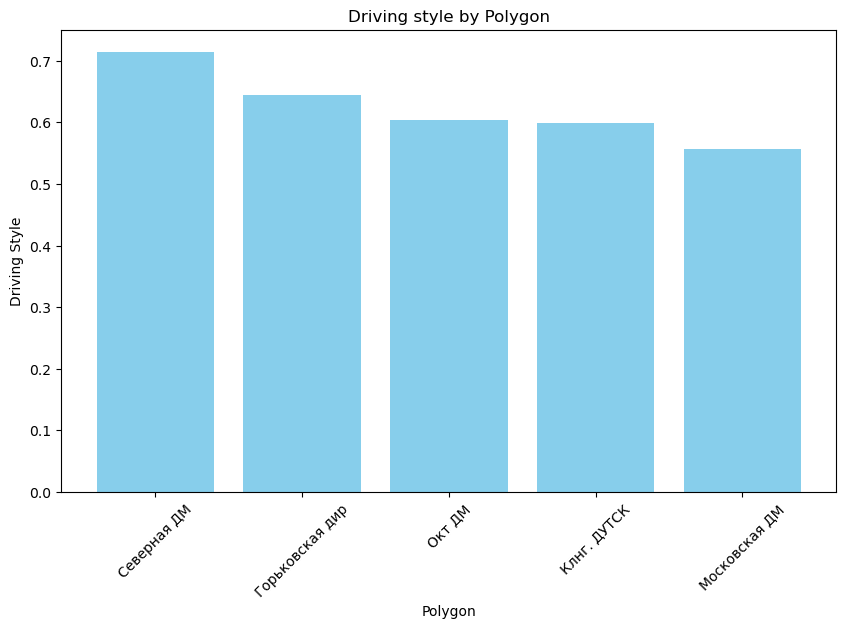

,polygon,driving_style_score
4,Северная ДМ,0.714530
0,Горьковская дир,0.644686
3,Окт ДМ,0.603292
1,Клнг. ДУТСК,0.599479
2,Московская ДМ,0.557078


In [67]:
graph1 = pd.DataFrame({'polygon': rate_polygons['polygon'], 'driving_style_score': rate_polygons['driving_style_score']})
graph1_sorted = graph1.sort_values(by='driving_style_score', ascending=False)
graph1_sorted

plt.figure(figsize=(10, 6))
plt.bar(graph1_sorted['polygon'], graph1_sorted['driving_style_score'], color='skyblue')
plt.xlabel('Polygon')
plt.ylabel('Driving Style')
plt.title('Driving style by Polygon')
plt.xticks(rotation=45)
plt.show()

graph1_sorted

## Штрафы

In [68]:
graph1 = pd.DataFrame({'polygon': rate_polygons['polygon'], 'penalty': rate_polygons['penalty']})
graph1_sorted = graph1.sort_values(by='penalty')

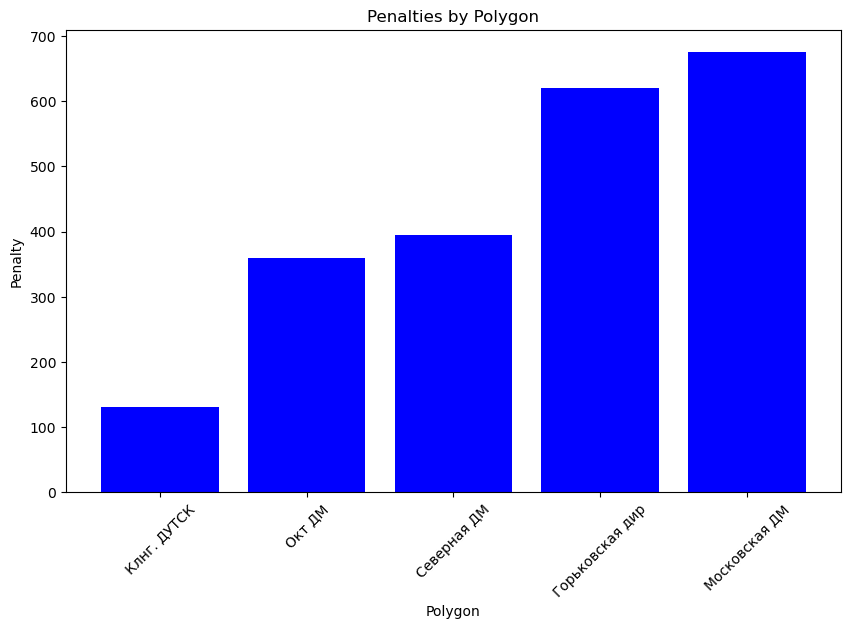

In [69]:
plt.figure(figsize=(10,6))
plt.bar(graph1_sorted['polygon'], graph1_sorted['penalty'], color='blue')
plt.xlabel('Polygon')
plt.ylabel('Penalty')
plt.title('Penalties by Polygon')
plt.xticks(rotation=45)
plt.show()

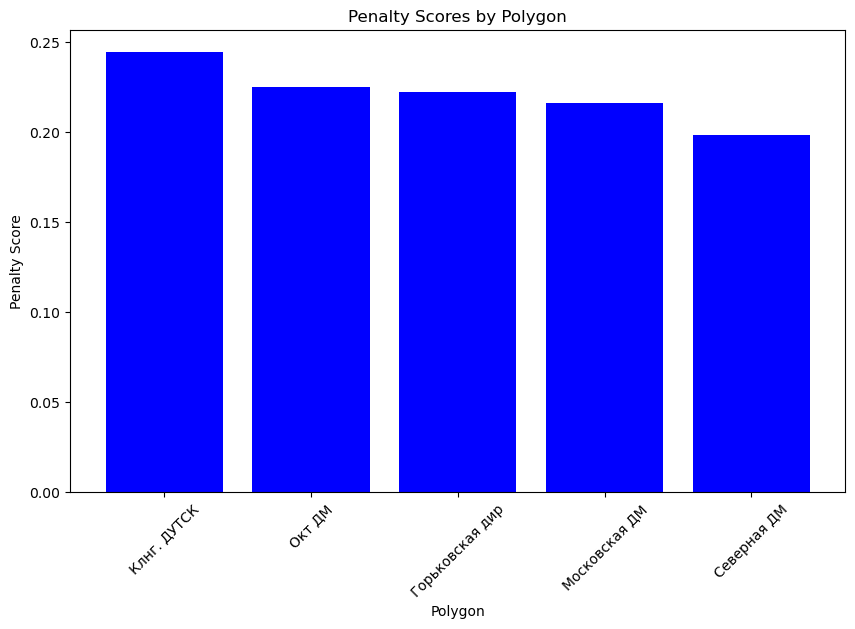

In [70]:
res = pd.DataFrame({'polygon': rate_polygons['polygon'], 'res': rate_polygons['penalty_score']})
res_sorted = res.sort_values(by='res', ascending=False)

plt.figure(figsize=(10,6))
plt.bar(res_sorted['polygon'], res_sorted['res'], color='blue')
plt.xlabel('Polygon')
plt.ylabel('Penalty Score')
plt.title('Penalty Scores by Polygon')
plt.xticks(rotation=45)
plt.show()

# Пробег

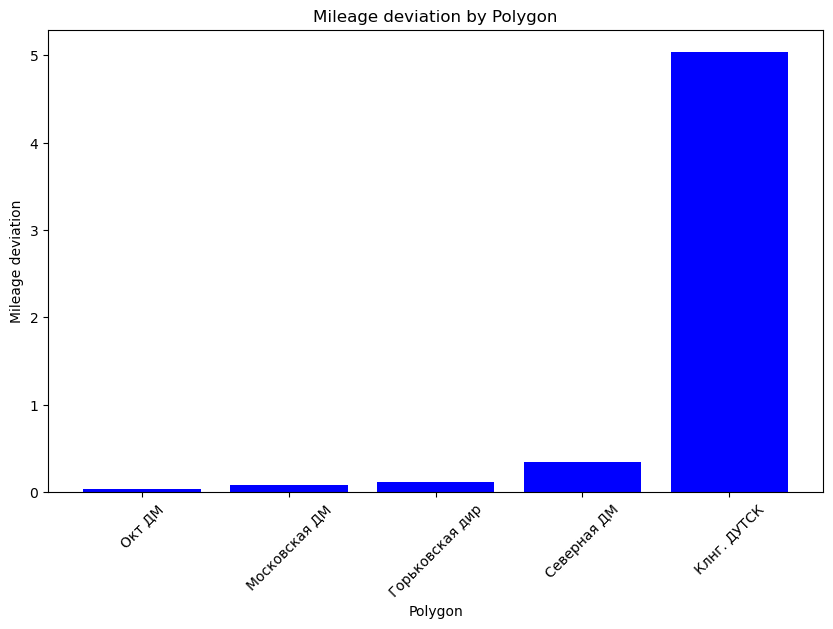

,polygon,mileage_deviation
3,Окт ДМ,0.034095
2,Московская ДМ,0.073917
0,Горьковская дир,0.108961
4,Северная ДМ,0.344475
1,Клнг. ДУТСК,5.041310


In [71]:
graph1 = pd.DataFrame({'polygon': rate_polygons['polygon'], 'mileage_deviation': rate_polygons['mileage_deviation']})
graph1_sorted = graph1.sort_values(by='mileage_deviation')

plt.figure(figsize=(10,6))
plt.bar(graph1_sorted['polygon'], graph1_sorted['mileage_deviation'], color='blue')
plt.xlabel('Polygon')
plt.ylabel('Mileage deviation')
plt.title('Mileage deviation by Polygon')
plt.xticks(rotation=45)
plt.show()

graph1_sorted

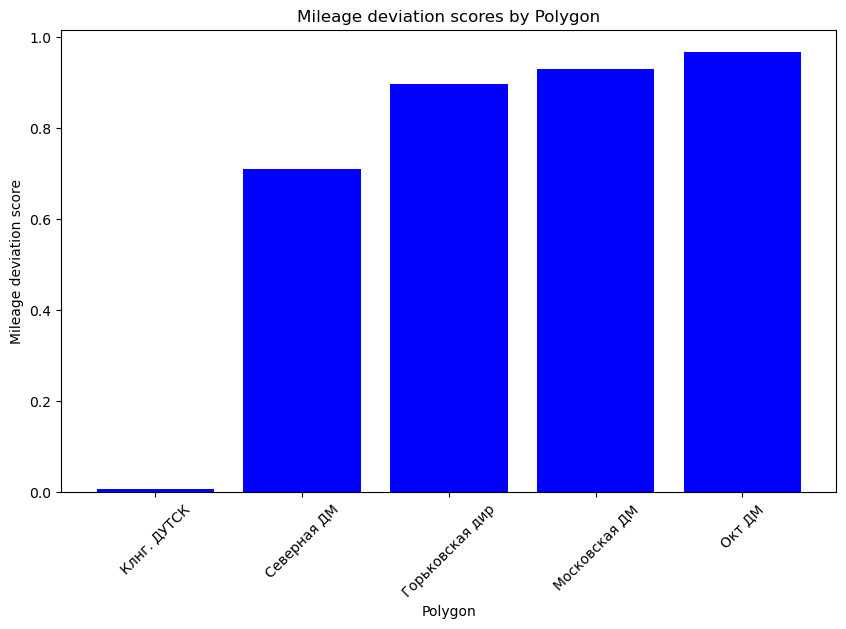

,polygon,mileage_deviation_score
1,Клнг. ДУТСК,0.006465
4,Северная ДМ,0.708592
0,Горьковская дир,0.896766
2,Московская ДМ,0.928749
3,Окт ДМ,0.966480


In [72]:
graph1 = pd.DataFrame({'polygon': rate_polygons['polygon'], 'mileage_deviation': rate_polygons['mileage_deviation']})
graph1_sorted = graph1.sort_values(by='mileage_deviation')

plt.figure(figsize=(10,6))
plt.bar(graph1_sorted['polygon'], graph1_sorted['mileage_deviation'], color='blue')
plt.xlabel('Polygon')
plt.ylabel('Penalty')
plt.title('Penalties by Polygon')
plt.xticks(rotation=45)
plt.show()

graph1_sorted

# Конечный скор

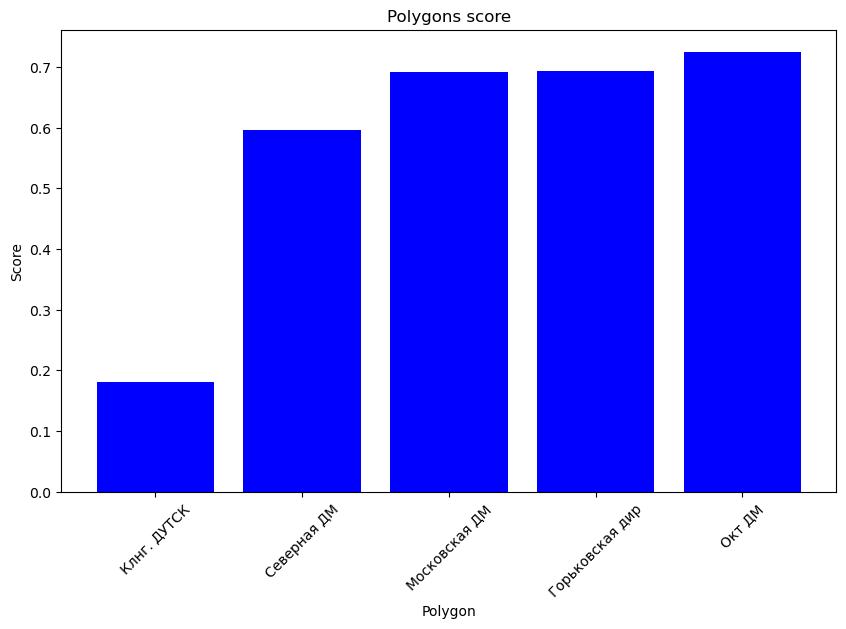

,polygon,result_score
1,Клнг. ДУТСК,0.180874
4,Северная ДМ,0.595522
2,Московская ДМ,0.691728
0,Горьковская дир,0.693207
3,Окт ДМ,0.724835


In [86]:
graph1 = pd.DataFrame({'polygon': rate_polygons['polygon'], 'result_score': rate_polygons['result_score']})
graph1_sorted = graph1.sort_values(by='result_score')

plt.figure(figsize=(10,6))
plt.bar(graph1_sorted['polygon'], graph1_sorted['result_score'], color='blue')
plt.xlabel('Polygon')
plt.ylabel('Score')
plt.title('Polygons score')
plt.xticks(rotation=45)
plt.show()

graph1_sorted

# Распределение транспорта

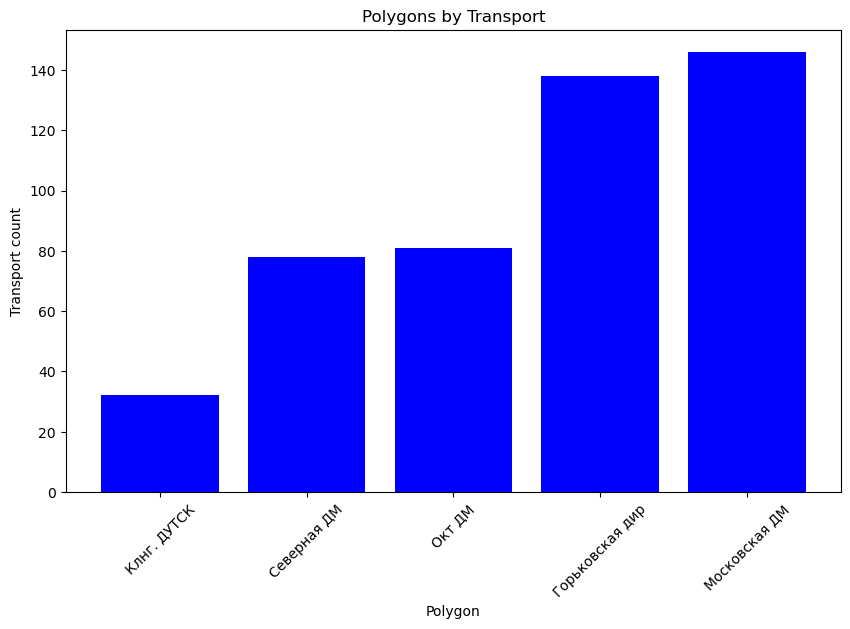

,polygon,cnt
1,Клнг. ДУТСК,32
4,Северная ДМ,78
3,Окт ДМ,81
0,Горьковская дир,138
2,Московская ДМ,146


In [89]:
graph1 = pd.DataFrame({'polygon': rate_polygons['polygon'], 'cnt': rate_polygons['cnt']})
graph1_sorted = graph1.sort_values(by='cnt')

plt.figure(figsize=(10,6))
plt.bar(graph1_sorted['polygon'], graph1_sorted['cnt'], color='blue')
plt.xlabel('Polygon')
plt.ylabel('Transport count')
plt.title('Polygons by Transport')
plt.xticks(rotation=45)
plt.show()

graph1_sorted

In [118]:
init_stract = df[df.leader == True].groupby('polygon')[['polygon']].count().rename(columns={'polygon': 'count_car'})
init_stract = init_stract.reset_index()
for elem in df['subpolygon'].unique(): 
    init_stract[elem] = [len(df[(df.leader == True) & (df['subpolygon'] == elem) & (df['polygon'] == i)]) for i in init_stract['polygon'].unique()]
init_stract

,polygon,count_car,ГТС Выборг,Московская механизированная дистанция ОКТ ДМ (МЧ-1),NaN,Калининградская ДМ,МЧ-01 г.Калининград,Московская механизированная дистанция погрузочно-разгрузочных рабо#,Брянско-Смоленская механизированная дистанция погрузочно-разгрузоч#,Орловская механизированная дистанция погрузочно-разгрузочных работ,ДМУ-3,ДМУ-4,ДМУ-2,Котласская механизированная дистанция ПРР и КО,Архангельская механизированная дистанция ПРР и КО
0,Горьковская дир,138,0,0,0,0,0,0,0,0,25,39,74,0,0
1,Клнг. ДУТСК,32,0,0,0,18,14,0,0,0,0,0,0,0,0
2,Московская ДМ,147,0,0,0,0,0,79,27,39,0,0,0,0,0
3,Окт ДМ,81,51,27,0,0,0,0,0,0,0,0,0,0,0
4,Северная ДМ,78,0,0,0,0,0,0,0,0,0,0,0,28,50


In [119]:
init_stract['polygon'].unique()

array(['Горьковская дир', 'Клнг. ДУТСК', 'Московская ДМ', 'Окт ДМ',
       'Северная ДМ'], dtype=object)

In [120]:
df['subpolygon'].unique()

array(['ГТС Выборг',
       'Московская механизированная дистанция ОКТ ДМ (МЧ-1)', nan,
       'Калининградская ДМ', 'МЧ-01 г.Калининград',
       'Московская механизированная дистанция погрузочно-разгрузочных рабо#',
       'Брянско-Смоленская механизированная дистанция погрузочно-разгрузоч#',
       'Орловская механизированная дистанция погрузочно-разгрузочных работ',
       'ДМУ-3', 'ДМУ-4', 'ДМУ-2',
       'Котласская механизированная дистанция ПРР и КО',
       'Архангельская механизированная дистанция ПРР и КО'], dtype=object)

In [140]:
data_col_stract = {
    'polygon': [],
    'polygon_count': [],
    'subpolygon': [],
    'subpolygon_count': [],
    'res': [],
}
for i in init_stract['polygon']:
    tmp = init_stract[init_stract['polygon'] == i]
    tmp = tmp.loc[:, (tmp != 0).any(axis=0)]
    for elem in tmp.columns[2:]:
        data_col_stract['polygon'].append(i)
        data_col_stract['polygon_count'].append(tmp['count_car'].values[0])
        data_col_stract['subpolygon'].append(elem)
        data_col_stract['subpolygon_count'].append(tmp[elem].values[0])
        data_col_stract['res'].append(tmp[elem].values[0] / tmp['count_car'].values[0])

data_init_stract = pd.DataFrame(data_col_stract)
data_init_stract = data_init_stract.set_index('subpolygon')

In [146]:
data_init_stract

,polygon,polygon_count,subpolygon_count,res
subpolygon,,,,
ДМУ-3,Горьковская дир,138,25,0.181159
ДМУ-4,Горьковская дир,138,39,0.282609
ДМУ-2,Горьковская дир,138,74,0.536232
Калининградская ДМ,Клнг. ДУТСК,32,18,0.562500
МЧ-01 г.Калининград,Клнг. ДУТСК,32,14,0.437500
Московская механизированная дистанция погрузочно-разгрузочных рабо#,Московская ДМ,147,79,0.537415
Брянско-Смоленская механизированная дистанция погрузочно-разгрузоч#,Московская ДМ,147,27,0.183673
Орловская механизированная дистанция погрузочно-разгрузочных работ,Московская ДМ,147,39,0.265306
ГТС Выборг,Окт ДМ,81,51,0.629630


In [149]:
subpolygons_to_polygons = data_init_stract[['polygon']]

In [152]:
rate_subpolygons_group = df[df.leader == True].groupby('subpolygon')
rate_subpolygons = get_polygons_rate(rate_subpolygons_group).drop(columns=['result_score'])
rate_subpolygons = rate_subpolygons.join(data_init_stract.rename(columns={'res': 'subpolygon_cars_deviation'})[['subpolygon_cars_deviation']])

rate_subpolygons['polygon'] = subpolygons_to_polygons.loc[rate_subpolygons.index]

rate_subpolygons['subpolygon_cars_score'] = rate_subpolygons['subpolygon_cars_deviation']

rate_subpolygons['result_score'] = rate_subpolygons['mileage_deviation_score'] * 0.4 + rate_subpolygons['subpolygon_cars_score'] * 0.3 + rate_subpolygons['penalty_score'] * 0.15 + rate_subpolygons['driving_style_score'] * 0.15

rate_subpolygons

,mileage_list,mileage_telematics,penalty,driving_style,cnt,mileage_deviation,mileage_deviation_score,driving_style_score,penalty_score,subpolygon_cars_deviation,polygon,subpolygon_cars_score,result_score
subpolygon,,,,,,,,,,,,,
Архангельская механизированная дистанция ПРР и КО,236594.14,184887.71,305.0,4.428000,50,0.279664,7.560378e-01,0.738000,0.163934,0.641026,Северная ДМ,0.641026,0.630013
Брянско-Смоленская механизированная дистанция погрузочно-разгрузоч#,39128.90,40114.50,184.0,4.511111,27,0.024570,9.757297e-01,0.751852,0.146739,0.183673,Московская ДМ,0.183673,0.580183
ГТС Выборг,20597.68,21350.77,209.0,4.200000,51,0.035272,9.653426e-01,0.700000,0.244019,0.629630,Окт ДМ,0.629630,0.716629
ДМУ-2,115101.77,98184.86,333.0,3.781081,74,0.172297,8.417295e-01,0.630180,0.222222,0.536232,Горьковская дир,0.536232,0.625422
ДМУ-3,17092.50,18736.76,170.0,3.920000,25,0.087756,9.159845e-01,0.653333,0.147059,0.181159,Горьковская дир,0.181159,0.540800
ДМУ-4,31594.00,30773.66,118.0,4.000000,39,0.026657,9.736950e-01,0.666667,0.330508,0.282609,Горьковская дир,0.282609,0.623837
Калининградская ДМ,1388.43,2989.79,56.0,3.322222,18,0.535610,5.853124e-01,0.553704,0.321429,0.562500,Клнг. ДУТСК,0.562500,0.534145
Котласская механизированная дистанция ПРР и КО,38806.00,19950.72,89.0,4.035714,28,0.945093,3.886435e-01,0.672619,0.314607,0.358974,Северная ДМ,0.358974,0.411234
МЧ-01 г.Калининград,26514.99,1628.98,75.0,3.950000,14,15.277051,2.318789e-07,0.658333,0.186667,0.437500,Клнг. ДУТСК,0.437500,0.258000


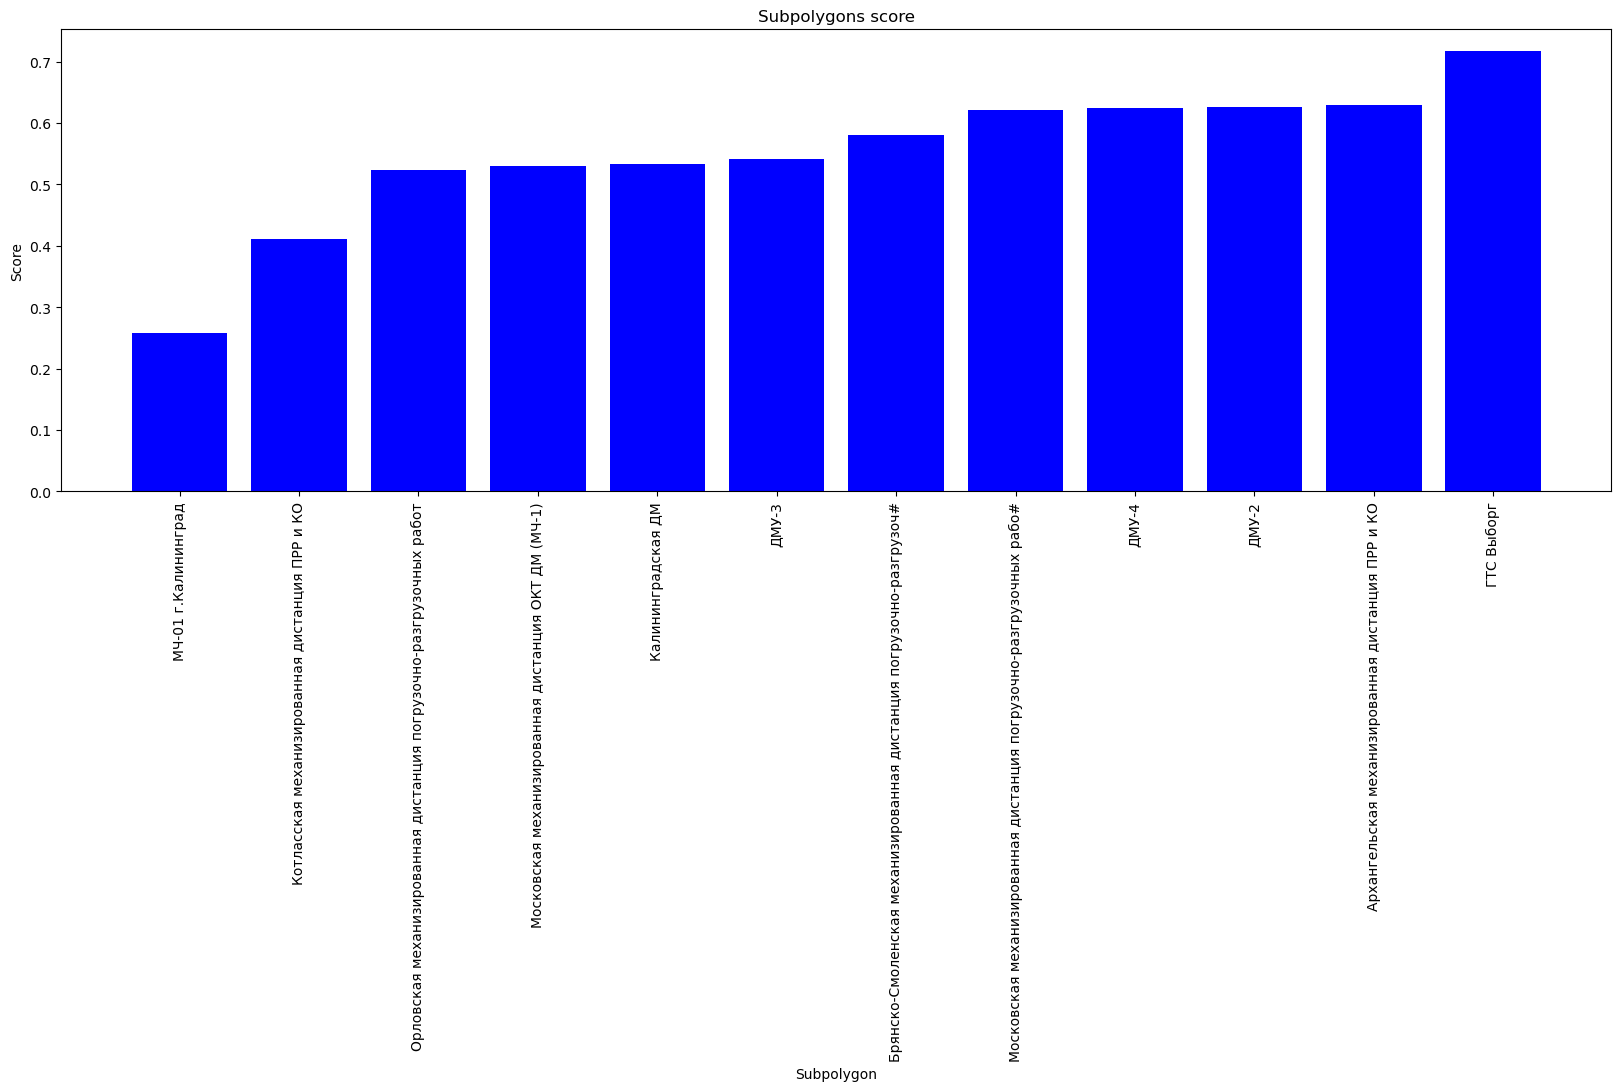

,subpolygon,result_score
subpolygon,,
МЧ-01 г.Калининград,МЧ-01 г.Калининград,0.258000
Котласская механизированная дистанция ПРР и КО,Котласская механизированная дистанция ПРР и КО,0.411234
Орловская механизированная дистанция погрузочно-разгрузочных работ,Орловская механизированная дистанция погрузочн...,0.523132
Московская механизированная дистанция ОКТ ДМ (МЧ-1),Московская механизированная дистанция ОКТ ДМ (...,0.530469
Калининградская ДМ,Калининградская ДМ,0.534145
ДМУ-3,ДМУ-3,0.540800
Брянско-Смоленская механизированная дистанция погрузочно-разгрузоч#,Брянско-Смоленская механизированная дистанция ...,0.580183
Московская механизированная дистанция погрузочно-разгрузочных рабо#,Московская механизированная дистанция погрузоч...,0.620977
ДМУ-4,ДМУ-4,0.623837


In [157]:
graph1 = pd.DataFrame({'subpolygon': rate_subpolygons.index, 'result_score': rate_subpolygons['result_score']})
graph1_sorted = graph1.sort_values(by='result_score')

plt.figure(figsize=(20,6))
plt.bar(graph1_sorted['subpolygon'], graph1_sorted['result_score'], color='blue')
plt.xlabel('Subpolygon')
plt.ylabel('Score')
plt.title('Subpolygons score')
plt.xticks(rotation=90)
plt.show()

graph1_sorted

# Разные аггрегации

In [73]:
df

,leader,polygon,id,subpolygon,stating_type,date_list,mileage_list,date_telematics,mileage_telematics,penalty,driving_style
0,True,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,NaT,158.0,NaT,140.26,17.0,3.5
1,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-04,9.0,2024-04-02,3.00,1.0,3.5
2,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-08,5.0,2024-04-08,5.00,1.0,3.5
3,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-09,7.0,2024-04-09,7.00,1.0,3.5
4,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-10,12.0,2024-04-10,12.00,2.0,3.5
...,...,...,...,...,...,...,...,...,...,...,...
4396,False,Северная ДМ,Р390ХН07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,2024-04-28,8.0,2024-04-28,8.00,1.0,5.2
4397,False,Северная ДМ,Р390ХН07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,2024-04-30,46.0,2024-04-30,46.00,1.0,5.2
4398,True,Северная ДМ,М777КХ07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,NaT,11.0,NaT,0.00,0.0,5.3
4399,False,Северная ДМ,М777КХ07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,2024-04-05,3.0,NaT,NaN,9.0,5.3


In [75]:
def collect_groups_by_date(df: pd.DataFrame):
	df = df.copy()
	tdf = df[df.leader == False].groupby(['polygon', 'date'])[['penalty', 'mileage_list', 'mileage_telematics']].sum()
	tdf = tdf.join(df[df.leader == False].groupby(['polygon', 'date'])[['driving_style']].mean())

	return tdf

In [76]:
poldatel_gb = collect_groups_by_date(df.rename(columns={'date_list': 'date'}))
poldatet_gb = collect_groups_by_date(df.rename(columns={'date_telematics': 'date'}))

In [77]:
poldate_data = poldatel_gb.join(poldatet_gb, on=['polygon', 'date'], lsuffix='_list', rsuffix='_telematics')

In [113]:
poldate_data['penalty_error'] = (poldate_data['penalty_list'] - poldate_data['penalty_telematics']) ** 2
poldate_data['driving_style_error'] = (poldate_data['driving_style_list'] - poldate_data['driving_style_telematics']) ** 2
poldate_data['mileage_error_list'] = (poldate_data['mileage_list_list'] - poldate_data['mileage_telematics_list']) ** 2
poldate_data['mileage_error_telematics'] = (poldate_data['mileage_list_telematics'] - poldate_data['mileage_telematics_telematics']) ** 2

In [114]:
poldate_data

penalty_list  mileage_list_list  \
polygon         date                                          
Горьковская дир 2024-04-01          26.0            8103.41   
                2024-04-02          10.0            3443.00   
                2024-04-03          26.0            6711.00   
                2024-04-04          14.0            5093.00   
                2024-04-05          18.0            5025.00   
...                                  ...                ...   
Северная ДМ     2024-04-26          32.0           10237.30   
                2024-04-27          17.0            3452.00   
                2024-04-28          21.0            8977.00   
                2024-04-29          15.0            6632.00   
                2024-04-30          16.0            6086.00   

                            mileage_telematics_list  driving_style_list  \
polygon         date                                                      
Горьковская дир 2024-04-01                  4871.00            4.940000   
                2024-04-02                  1730.00            4.900000   
                2024-04-03                  3393.00            5.030769   
                2024-04-04                  3076.00            5.178571   
                2024-04-05                  2478.00            5.133333   
...                                             ...                 ...   
Северная ДМ     2024-04-26                  5280.72            5.106250   
                2024-04-27                  2501.65            5.223529   
                2024-04-28                  4338.00            5.085714   
                2024-04-29                  4351.00            5.120000   
                2024-04-30                  3313.00            5.125000   

                            penalty_telematics  mileage_list_telematics  \
polygon         date                                                      
Горьковская дир 2024-04-01                40.0                  4331.00   
                2024-04-02                10.0                  1730.00   
                2024-04-03                26.0                  2685.00   
                2024-04-04                19.0                  3833.00   
                2024-04-05                21.0                  2823.00   
...                                        ...                      ...   
Северная ДМ     2024-04-26                21.0                  4468.58   
                2024-04-27                10.0                  2497.00   
                2024-04-28                13.0                  4622.00   
                2024-04-29                 9.0                  4422.00   
                2024-04-30                14.0                  2845.00   

                            mileage_telematics_telematics  \
polygon         date                                        
Горьковская дир 2024-04-01                        8768.20   
                2024-04-02                        1957.00   
                2024-04-03                        6944.00   
                2024-04-04                        7089.00   
                2024-04-05                        4045.00   
...                                                   ...   
Северная ДМ     2024-04-26                        6621.72   
                2024-04-27                        3452.65   
                2024-04-28                        5281.00   
                2024-04-29                        4362.00   
                2024-04-30                        4433.00   

                            driving_style_telematics  penalty_error  \
polygon         date                                                  
Горьковская дир 2024-04-01                  4.870270          196.0   
                2024-04-02                  4.960000            0.0   
                2024-04-03                  4.911538            0.0   
                2024-04-04                  5.157895           25.0   
                2024-04-05          

In [115]:
agg_1 = poldate_data.loc['Горьковская дир']

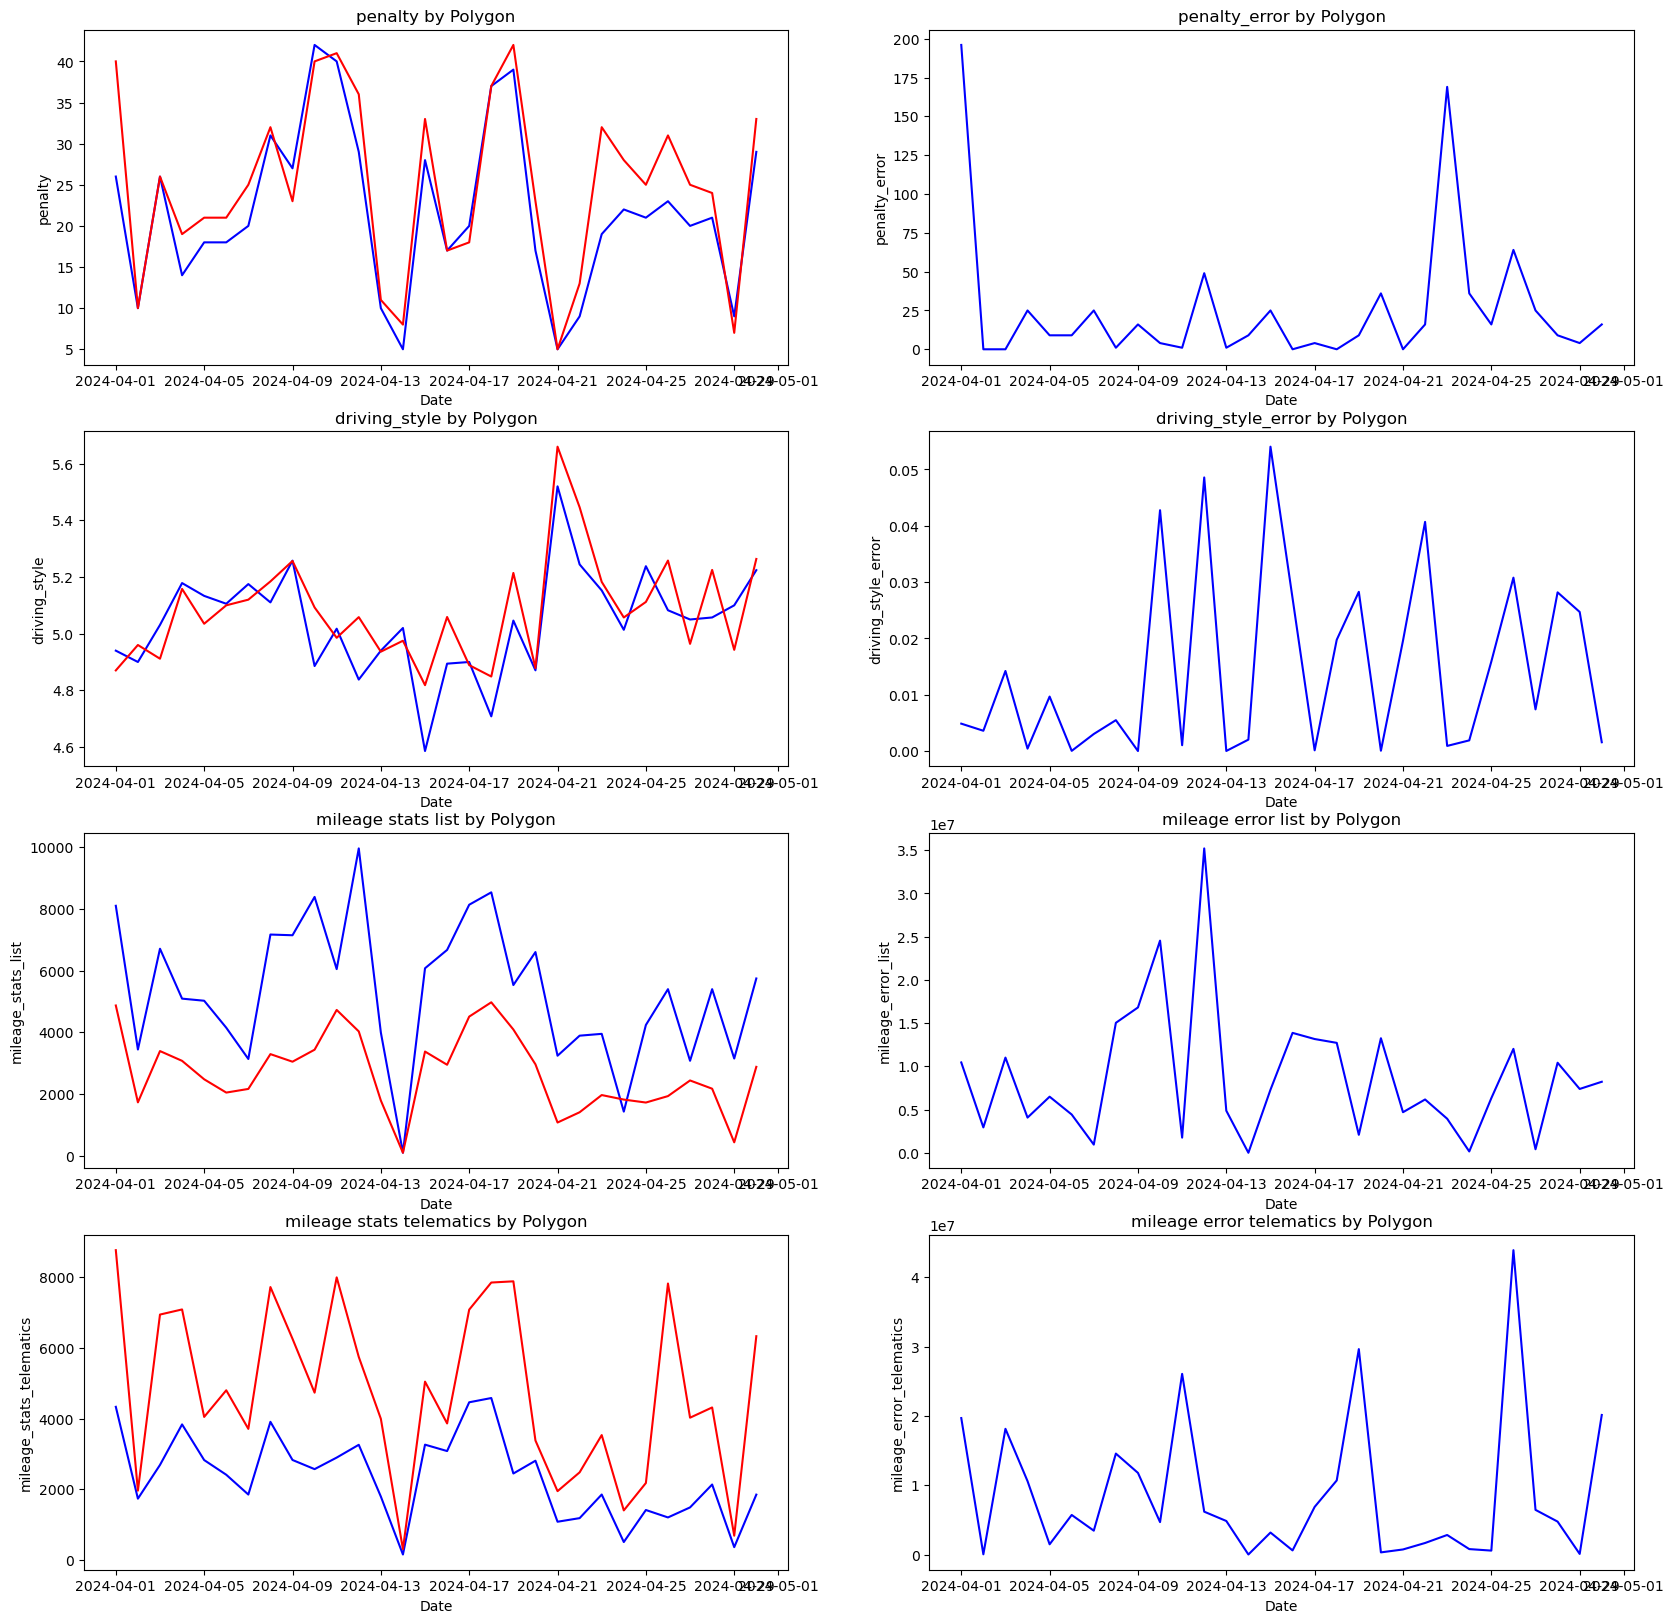

In [116]:
cols = ['penalty', 'penalty_error', 'driving_style', 'driving_style_error']

fig, axs = plt.subplots(4, 2, figsize = (20, 20))

i = 0
		
for axx in axs[:2]:
	ax = axx[0]
	ax.plot(agg_1.index, agg_1[cols[i]+'_list'], color='blue')
	ax.plot(agg_1.index, agg_1[cols[i]+'_telematics'], color='red')
	ax.set_ylabel(cols[i])
	ax.set_xlabel('Date')
	ax.set_title(cols[i] + ' by Polygon')

	i += 1

	ax = axx[1]
	ax.plot(agg_1.index, agg_1[cols[i]], color='blue')
	ax.set_ylabel(cols[i])
	ax.set_xlabel('Date')
	ax.set_title(cols[i] + ' by Polygon')



	i += 1


ax = axs[2][0]
ax.plot(agg_1.index, agg_1['mileage_list_list'], color='blue')
ax.plot(agg_1.index, agg_1['mileage_telematics_list'], color='red')
ax.set_ylabel('mileage_stats_list')
ax.set_xlabel('Date')
ax.set_title('mileage stats list by Polygon')

ax = axs[2][1]
ax.plot(agg_1.index, agg_1['mileage_error_list'], color='blue')
ax.set_ylabel('mileage_error_list')
ax.set_xlabel('Date')
ax.set_title('mileage error list by Polygon')

i+= 1

ax = axs[3][0]
ax.plot(agg_1.index, agg_1['mileage_list_telematics'], color='blue')
ax.plot(agg_1.index, agg_1['mileage_telematics_telematics'], color='red')
ax.set_ylabel('mileage_stats_telematics')
ax.set_xlabel('Date')
ax.set_title('mileage stats telematics by Polygon')

ax = axs[3][1]
ax.plot(agg_1.index, agg_1['mileage_error_telematics'], color='blue')
ax.set_ylabel('mileage_error_telematics')
ax.set_xlabel('Date')
ax.set_title('mileage error telematics by Polygon')


plt.show()

In [92]:
def absolute_error()

,leader,polygon,id,subpolygon,stating_type,date_list,mileage_list,date_telematics,mileage_telematics,penalty,driving_style
0,True,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,NaT,158.0,NaT,140.26,17.0,3.5
1,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-04,9.0,2024-04-02,3.00,1.0,3.5
2,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-08,5.0,2024-04-08,5.00,1.0,3.5
3,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-09,7.0,2024-04-09,7.00,1.0,3.5
4,False,Окт ДМ,Б/Н,ГТС Выборг,В целевой структуре парка,2024-04-10,12.0,2024-04-10,12.00,2.0,3.5
...,...,...,...,...,...,...,...,...,...,...,...
4396,False,Северная ДМ,Р390ХН07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,2024-04-28,8.0,2024-04-28,8.00,1.0,5.2
4397,False,Северная ДМ,Р390ХН07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,2024-04-30,46.0,2024-04-30,46.00,1.0,5.2
4398,True,Северная ДМ,М777КХ07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,NaT,11.0,NaT,0.00,0.0,5.3
4399,False,Северная ДМ,М777КХ07,Архангельская механизированная дистанция ПРР и КО,В целевой структуре парка,2024-04-05,3.0,NaT,NaN,9.0,5.3
